<a href="https://colab.research.google.com/github/oyeyemixisco/Image_Captioning_Model/blob/main/Image_Captioning_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Captioning ML Model

This model detect the object in image and provide the a suited caption for the event in it.

It's an encoder-decoder model leveraging CNN, where the encoder output
embedding of an input image, and the decoder output text from the image embedding. Let's dive into it

For example, given an image like this:

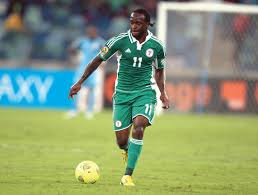

the model is expected to generate a caption such as "Someone playing football."

In [ ]:
#importing neccessary dependecies and dataset from tensorflow

import time
from textwrap import wrap
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
 GRU,
 Add,
 AdditiveAttention,
 Attention,
 Concatenate,
 Dense,
 Embedding,
 LayerNormalization,
 Reshape,
 StringLookup,
 TextVectorization,
)
print(tf.version.VERSION)

2.18.0


## Read and prepare dataset
We will use the TensorFlow datasets capability to read the COCO captions dataset. This version contains images, bounding boxes, labels, and captions from COCO 2014

more about the [COCO captions dataset](https://www.tensorflow.org/datasets/catalog/coco_captions)

In [ ]:
#Declaring the hyperparameters
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000 # use fewer words to speed up convergence
ATTENTION_DIM = 512 # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# Declaring the model we are using: InceptionResNetV2 (CNN-based model)
# takes (299, 299, 3) image as inputs and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
 include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Here we load the dataset from tfds (tensorflow datasets) and preprocess it

In [ ]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000

def get_image_label(example):
 caption = example["captions"]["text"][0] # only the first caption per image
 img = example["image"]
 img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
 img = img / 255
 return {"image_tensor": img, "caption": caption}

#load dataset from tfds
trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

#Passing pre-processing function like the 'get_image_label' function declared above
trainds = trainds.map(
 get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Visualize
Let's take a look at images and sample captions in the dataset.


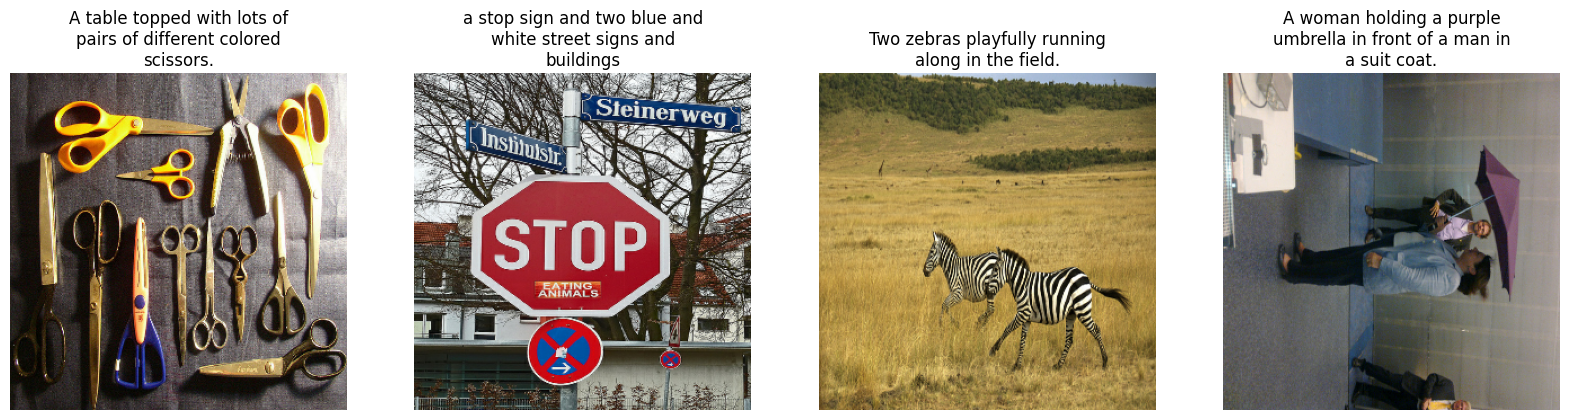

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
 ax[idx].imshow(data["image_tensor"].numpy())
 caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
 ax[idx].set_title(caption)
 ax[idx].axis("off")


## Text Preprocessing

SInce we have a text data, we need to preprocess the dataset.

We add special tokens to represent the starts (<start>) and the ends (<end>) of sentences.
Start and end tokens are added here because we are using an encoder-decoder model and during
prediction, to get the captioning started we use <start> and since captions are of variable length, we
terminate the prediction when we see the <end> token.

In [ ]:
def add_start_end_token(data):
 start = tf.convert_to_tensor("<start>") # the beginning of the sentence
 end = tf.convert_to_tensor("<end>") # the end of the sentence
 data["caption"] = tf.strings.join(
 [start, data["caption"], end], separator=" "
 )
 return data
trainds = trainds.map(add_start_end_token)

Now that we have text, we need to tokenize the text to machine understandable format, using the TextVectorization layer.

In [ ]:
MAX_CAPTION_LEN = 64  # the max length of generated caption

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
 inputs = tf.strings.lower(inputs)
 return tf.strings.regex_replace(
 inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
 )
# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
 max_tokens=VOCAB_SIZE,
 standardize=standardize,
 output_sequence_length=MAX_CAPTION_LEN,
)
tokenizer.adapt(trainds.map(lambda x: x["caption"]))


In [ ]:
# Let's try to tokenize a sample text

tokenizer(["<start> This is a sentence to tokenize <end>"])

#padding will be attached if the sentence is not up to 64 word length

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 165,  11,   2,   1,  13,   1,   4,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [ ]:
sample_captions = []
for d in trainds.take(5):
 sample_captions.append(d["caption"].numpy())
sample_captions

[b'<start> Two green signs that are on a wooden pole. <end>',
 b'<start> People are flying their kites in the sky. <end>',
 b'<start> A person catching a Frisbee in their hands. <end>',
 b'<start> a cat sitting on some leaves underneath a tree <end>',
 b'<start> A man riding down the side of a skateboard ramp at a skate park. <end>']

In [ ]:
print(tokenizer(sample_captions))

tf.Tensor(
[[  3  17  53 246  28  24   6   2  78 263   4   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3  20  24  74 130 259   8   7 131   4   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3   2  33 597   2 116   8 130 365   4   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3   2  51  14   6  36 487 466   2 127   4   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0 

**If you observe the tokenized output, all the sentenses starts and ends with the same token (e.g. '3' and '4'). These values
represent start tokens and end tokens respectively.**


Let's convert ids to original text for verification

In [ ]:
# printing the third sentence
for wordid in tokenizer([sample_captions[2]])[0]:
 print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> a person catching a frisbee in their hands <end>                                                       

Also, we can create Word <-> Index converters using StringLookup layer.


In [ ]:
# Lookup table: Word -> Index
word_to_index = StringLookup(
 mask_token="", vocabulary=tokenizer.get_vocabulary()
)
# Lookup table: Index -> Word
index_to_word = StringLookup(
 mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

## Lets's create tensorflow  (tf.data) dataset for training
Now we will apply the adapted tokenization to all the examples and create tf.data Dataset for training.

In [ ]:
BATCH_SIZE = 32
def create_ds_fn(data):
 img_tensor = data["image_tensor"]
 caption = tokenizer(data["caption"])

 # Here we are also creating labels by shifting texts from feature captions
 target = tf.roll(caption, -1, 0)
 zeros = tf.zeros([1], dtype=tf.int64)
 target = tf.concat((target[:-1], zeros), axis=-1)
 return (img_tensor, caption), target


batched_ds = (
 trainds.map(create_ds_fn)
 .batch(BATCH_SIZE, drop_remainder=True)
 .prefetch(buffer_size=tf.data.AUTOTUNE)
)


Let's look at some examples

In [ ]:
for (img, caption), label in batched_ds.take(2):
 print(f"Image shape: {img.shape}")
 print(f"Caption shape: {caption.shape}")
 print(f"Label shape: {label.shape}")
 print(caption[0])
 print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2  42 153   9  95 199   8  35   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
tf.Tensor(
[  2  42 153   9  95 199   8  35   4   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3 2604    2   97    8    7  290    5    2   42  117   48    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    

## Model Development
Now let's design our image captioning model. It consists of an image encoder, followed by a caption decoder.

**Image encoder:** Extracts features through a pre-trained model and passes
them to a fully connected layer

In [ ]:
# We don't need to retrain the foundtional model:  InceptionResNetV2
# which is why the trainable is false
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)
x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
 image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [ ]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1536)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64, 512)             │         786,944 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,123,680 (210.28 MB)

 Trainable params: 786,944 (3.00 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

## Caption Decoder
The caption decoder incorporates an attention mechanism that focuses on different parts of the
input image.

The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a
sequence of vectors as input for each example and returns an "attention" vector for each example.


### The decoder's job is to generate predictions for the next output token.
1. The decoder receives current word tokens as a batch.
2. It embeds the word tokens to ATTENTION_DIM dimension.
3. GRU layer keeps track of the word embeddings, and returns GRU outputs and states.
4. Bahdanau-style attention attends over the encoder's output feature by using GRU outputs as
a query.
5. The attention outputs and GRU outputs are added (skip connection), and normalized in a
layer normalization layer.
6. It generates logit predictions for the next token based on the GRU output.

In [ ]:
word_input = Input(shape=(MAX_CAPTION_LEN,), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)
decoder_gru = GRU(
 ATTENTION_DIM,
 return_sequences=True,
 return_state=True,
)

gru_output, gru_state = decoder_gru(embed_x)
decoder_attention = Attention()

context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)


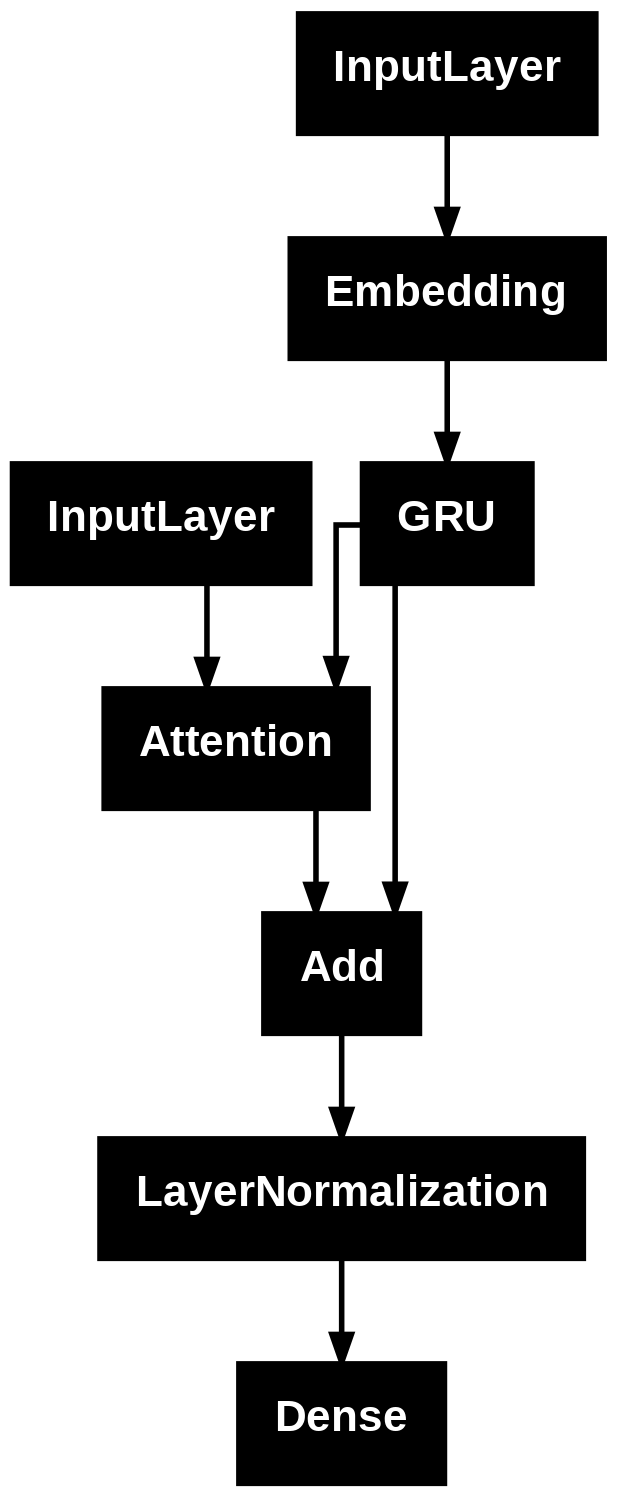

In [ ]:
decoder = tf.keras.Model(
 inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [ ]:
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ words (InputLayer)        │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 64, 512)        │     10,240,000 │ words[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ [(None, 64, 512),      │      1,575,936 │ embedding[1][0]        │
│                           │ (None, 512)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_1561CLONE    │ (None, 64, 512)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 64, 512)        │              0 │ gru[1][0],             │
│                           │                        │                │ keras_tensor_1561CLON… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 512)        │              0 │ gru[1][0],             │
│                           │                        │                │ attention[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 512)        │          1,024 │ add[1][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64, 20000)      │     10,260,000 │ layer_normalization[1… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 22,076,960 (84.22 MB)

 Trainable params: 22,076,960 (84.22 MB)

 Non-trainable params: 0 (0.00 B)

As seen in the above, it has so many parameters

Now, that we are done defining the Encoder and Decoder let's create the final model tf.Keras and define the input and output.

It has two inputs (image_inputs and word_inputs) and one output, the decoder_output

In [ ]:
image_caption_train_model = tf.keras.Model(
 inputs=[image_input, word_input], outputs=decoder_output
)

## Loss Function

Now that the model is ready, we need to define the loss function.

Loss function is a simple cross-entropy, but we need to remove padding (0) when calculating it.
So here we extract the length of the sentence (non-0 part), and compute the average of the loss only
over the valid sentence part.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
 from_logits=True, reduction="none"
)

def loss_function(real, pred):
 loss_ = loss_object(real, pred)
 # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 mask = tf.cast(mask, dtype=tf.int32)
 sentence_len = tf.reduce_sum(mask)
 loss_ = loss_[:sentence_len]

 return tf.reduce_mean(loss_, 1)


In [ ]:
image_caption_train_model.compile(
 optimizer="adam",
 loss=loss_function,
)

Let's run the training using the standard model.fit API.
It takes around 25 minutes.

Note: you can run more than one Epoch depending on your choice. One epoch is enough for the training purpose but if you want more model accuracy, it can be more than one.

In [ ]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=1)

 126/2586 ━━━━━━━━━━━━━━━━━━━━ 15:55:23 23s/step - loss: 2.3523

## Caption Model
The predict step is different from the training, since we need to keep track of the GRU state during
the caption generation, and pass a predicted word to the decoder as an input at the next time step.

In order to do so, let's define another model for prediction while using the trained weights, so that it
can keep and update the GRU state during the caption generation.

In [ ]:
gru_state_input = Input(shape=(ATTENTION_DIM,), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
 inputs=[word_input, gru_state_input, encoder_output],
 outputs=[decoder_output, gru_state],
)

In [ ]:
MINIMUM_SENTENCE_LENGTH = 8

## Probabilistic prediction using the trained model
def predict_caption(filename):
 gru_state = tf.zeros((1, ATTENTION_DIM))

 img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
 img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
 img = img / 255

 #parsing the image to the encoder
 features = encoder(tf.expand_dims(img, axis=0))

 # initiate the <start> token as the 1st word before parsing it into the decoder
 dec_input = tf.expand_dims([word_to_index("<start>")], 1)
 result = []

 for i in range(MAX_CAPTION_LEN):
    predictions, gru_state = decoder_pred_model(
        [dec_input, gru_state, features]
    )

    # draws from log distribution given by predictions
    top_probs, top_idxs = tf.math.top_k(
    input=predictions[0][0], k=10, sorted=False
    )

    chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
    predicted_id = top_idxs.numpy()[chosen_id][0]

    result.append(tokenizer.get_vocabulary()[predicted_id])

    if predicted_id == word_to_index("<end>"):
      return img, result

    dec_input = tf.expand_dims([predicted_id], 1)

 return img, result

Let's test our model with images

In [ ]:
filename = "rocket.jpeg" # you can also try surf.jpeg

#come up with 5 suited caption for the image
for i in range(5):
  image, caption = predict_caption(filename)
  print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename),
channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");